**DATASET**

In [2]:
import requests
import zipfile
import io
import pandas as pd
import os

# Replace 'url_to_your_zip_file' with the actual URL of the zipped dataset
url = "https://www.kaggle.com/api/v1/datasets/download/sid321axn/beijing-multisite-airquality-data-set"

# Fetch the zipped data
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad responses (4xx or 5xx)

# Extract the contents of the zip file
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall("temp_dataset")  # Extract to a temporary directory

# Get a list of all CSV files (or other relevant files) in the extracted directory
csv_files = [f for f in os.listdir("temp_dataset") if f.endswith('.csv')]

# Read the CSV files into pandas DataFrames (adjust if needed for other file types)
dfs = []

# Loop through each CSV file and read it into a dataframe
for file in csv_files:
    file_path = os.path.join("temp_dataset", file)
    df = pd.read_csv(file_path)

    # Extract Stations name from filename
    Stations_name = file.split('_')[2]  # Assuming Stations name is the third part of the filename
    df['Stations'] = Stations_name
    dfs.append(df)

# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(dfs, ignore_index=True)

combined_df

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,Stations
0,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,85.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Nongzhanguan,Nongzhanguan
1,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,84.0,-0.7,1025.1,-22.1,0.0,NW,3.9,Nongzhanguan,Nongzhanguan
2,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,83.0,-1.2,1025.3,-24.6,0.0,NNW,5.3,Nongzhanguan,Nongzhanguan
3,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,84.0,-1.4,1026.2,-25.5,0.0,N,4.9,Nongzhanguan,Nongzhanguan
4,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,77.0,-1.9,1027.1,-24.5,0.0,NNW,3.2,Nongzhanguan,Nongzhanguan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,35060,2017,2,28,19,13.0,37.0,3.0,36.0,400.0,60.0,12.5,1013.5,-16.2,0.0,NW,2.4,Guanyuan,Guanyuan
420764,35061,2017,2,28,20,20.0,43.0,4.0,48.0,500.0,43.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Guanyuan,Guanyuan
420765,35062,2017,2,28,21,16.0,33.0,5.0,39.0,500.0,50.0,10.8,1014.2,-13.3,0.0,NW,1.1,Guanyuan,Guanyuan
420766,35063,2017,2,28,22,11.0,24.0,5.0,47.0,500.0,41.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Guanyuan,Guanyuan


**EDA before Feature Engineering**

Information and statistical summary with visualizatioon for each pollutant

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 19 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   No        420768 non-null  int64  
 1   year      420768 non-null  int64  
 2   month     420768 non-null  int64  
 3   day       420768 non-null  int64  
 4   hour      420768 non-null  int64  
 5   PM2.5     412029 non-null  float64
 6   PM10      414319 non-null  float64
 7   SO2       411747 non-null  float64
 8   NO2       408652 non-null  float64
 9   CO        400067 non-null  float64
 10  O3        407491 non-null  float64
 11  TEMP      420370 non-null  float64
 12  PRES      420375 non-null  float64
 13  DEWP      420365 non-null  float64
 14  RAIN      420378 non-null  float64
 15  wd        418946 non-null  object 
 16  WSPM      420450 non-null  float64
 17  station   420768 non-null  object 
 18  Stations  420768 non-null  object 
dtypes: float64(11), int64(5), 

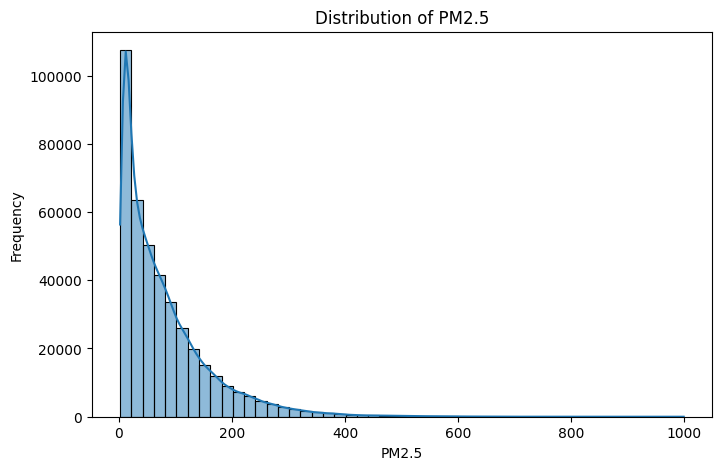

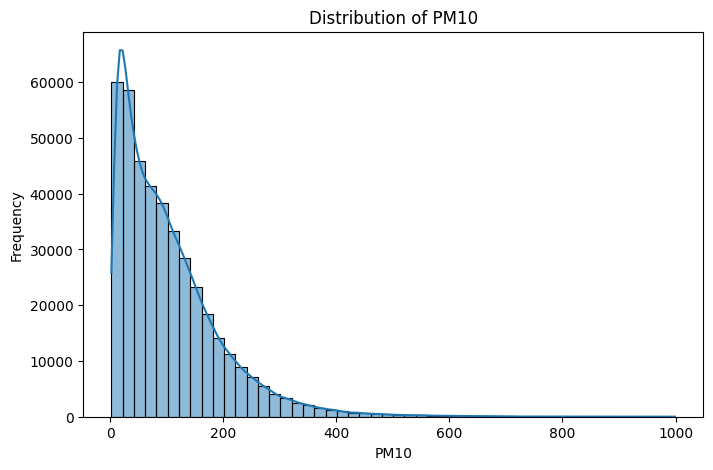

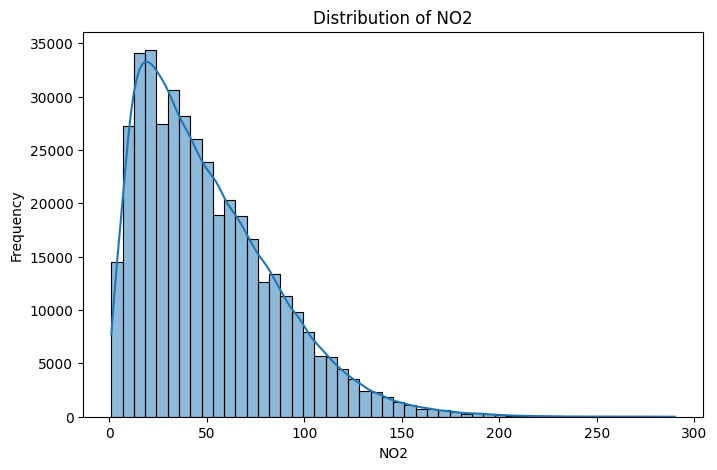

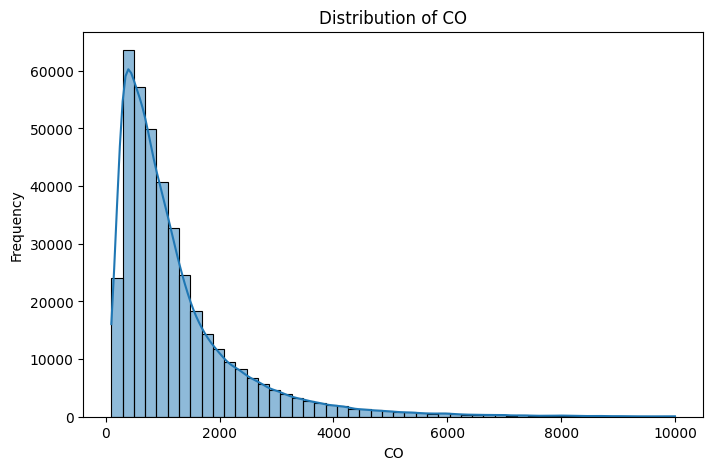

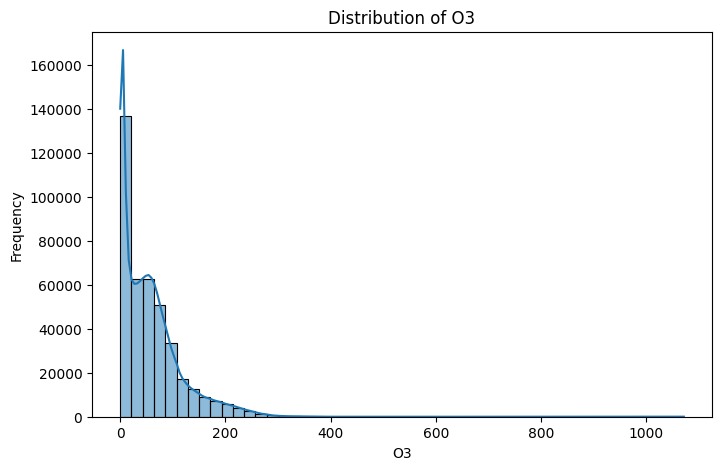

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic information about the dataset
print("Dataset Overview:")
print(combined_df.info())

# Statistical summary
print("\nStatistical Summary:")
print(combined_df.describe())

# Visualizing pollutant distributions
pollutants = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3']  # Adjust based on dataset columns
for pollutant in pollutants:
    plt.figure(figsize=(8, 5))
    sns.histplot(combined_df[pollutant].dropna(), kde=True, bins=50)
    plt.title(f'Distribution of {pollutant}')
    plt.xlabel(pollutant)
    plt.ylabel('Frequency')
    plt.show()

# **Feature Engineering**

**Cyclic features**

Wind Direction Transformation to Components

In [4]:
import numpy as np

# Mapping of cardinal wind directions to their corresponding degrees
wind_direction_degrees = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
    'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
    'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
    'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
}

# Function to convert wind direction to sine and cosine components
def calculate_wind_components(wind_dir):
    if wind_dir in wind_direction_degrees:
        radians = np.deg2rad(wind_direction_degrees[wind_dir])
        return np.sin(radians), np.cos(radians)
    else:
        return np.nan, np.nan

# Transform wind direction into sine and cosine components
sine_values, cosine_values = zip(*combined_df['wd'].map(calculate_wind_components))

# Append the sine and cosine components as new columns
combined_df['SinWindDir'] = sine_values
combined_df['CosWindDir'] = cosine_values

combined_df.head()


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,Stations,SinWindDir,CosWindDir
0,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,...,-0.5,1024.5,-21.4,0.0,NNW,5.7,Nongzhanguan,Nongzhanguan,-0.382683,0.923880
1,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,...,-0.7,1025.1,-22.1,0.0,NW,3.9,Nongzhanguan,Nongzhanguan,-0.707107,0.707107
2,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,...,-1.2,1025.3,-24.6,0.0,NNW,5.3,Nongzhanguan,Nongzhanguan,-0.382683,0.923880
3,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,...,-1.4,1026.2,-25.5,0.0,N,4.9,Nongzhanguan,Nongzhanguan,0.000000,1.000000
4,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,...,-1.9,1027.1,-24.5,0.0,NNW,3.2,Nongzhanguan,Nongzhanguan,-0.382683,0.923880


Calculate Wind Direction in degrees and Add Timestamp

In [5]:
# Convert 'year', 'month', 'day', and 'hour' to datetime objects
combined_df['Timestamp'] = pd.to_datetime(combined_df[['year', 'month', 'day', 'hour']])

# Function to convert wind direction to degrees
def wind_direction_to_degrees(wind_dir):
    if wind_dir in wind_direction_degrees:
        return wind_direction_degrees[wind_dir]
    else:
        return np.nan

# Calculate wind direction in degrees and add it to the DataFrame
combined_df['WindDir_degrees'] = combined_df['wd'].map(wind_direction_to_degrees)

combined_df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,DEWP,RAIN,wd,WSPM,station,Stations,SinWindDir,CosWindDir,Timestamp,WindDir_degrees
0,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,...,-21.4,0.0,NNW,5.7,Nongzhanguan,Nongzhanguan,-0.382683,0.923880,2013-03-01 00:00:00,337.5
1,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,...,-22.1,0.0,NW,3.9,Nongzhanguan,Nongzhanguan,-0.707107,0.707107,2013-03-01 01:00:00,315.0
2,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,...,-24.6,0.0,NNW,5.3,Nongzhanguan,Nongzhanguan,-0.382683,0.923880,2013-03-01 02:00:00,337.5
3,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,...,-25.5,0.0,N,4.9,Nongzhanguan,Nongzhanguan,0.000000,1.000000,2013-03-01 03:00:00,0.0
4,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,...,-24.5,0.0,NNW,3.2,Nongzhanguan,Nongzhanguan,-0.382683,0.923880,2013-03-01 04:00:00,337.5


Hour sin and cos

In [6]:
import numpy as np

combined_df['Hour_sin'] = np.sin(2 * np.pi * combined_df['hour'] / 24)
combined_df['Hour_cos'] = np.cos(2 * np.pi * combined_df['hour'] / 24)

combined_df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,wd,WSPM,station,Stations,SinWindDir,CosWindDir,Timestamp,WindDir_degrees,Hour_sin,Hour_cos
0,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,...,NNW,5.7,Nongzhanguan,Nongzhanguan,-0.382683,0.923880,2013-03-01 00:00:00,337.5,0.000000,1.000000
1,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,...,NW,3.9,Nongzhanguan,Nongzhanguan,-0.707107,0.707107,2013-03-01 01:00:00,315.0,0.258819,0.965926
2,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,...,NNW,5.3,Nongzhanguan,Nongzhanguan,-0.382683,0.923880,2013-03-01 02:00:00,337.5,0.500000,0.866025
3,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,...,N,4.9,Nongzhanguan,Nongzhanguan,0.000000,1.000000,2013-03-01 03:00:00,0.0,0.707107,0.707107
4,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,...,NNW,3.2,Nongzhanguan,Nongzhanguan,-0.382683,0.923880,2013-03-01 04:00:00,337.5,0.866025,0.500000


sin and cos components for day and month

In [7]:
import numpy as np

# Define the cyclic_normalizer function
def cyclic_normalizer(series):
    """
    Normalizes a cyclic feature (like month or day)
    into sine and cosine components.

    Args:
        series (pd.Series): The cyclic feature column.

    Returns:
        tuple: A tuple containing the sine and cosine components.
    """
    max_value = series.max()
    sin_component = np.sin(2 * np.pi * series / max_value)
    cos_component = np.cos(2 * np.pi * series / max_value)
    return sin_component, cos_component

# Now you can use the function in your code:
# Normalize 'Month' feature using cyclic normalizer
month_sin, month_cos = cyclic_normalizer(combined_df['month'])
combined_df['MonthSin'] = month_sin
combined_df['MonthCos'] = month_cos

# Normalize 'Day' feature using cyclic normalizer
day_sin, day_cos = cyclic_normalizer(combined_df['day'])
combined_df['DaySin'] = day_sin
combined_df['DayCos'] = day_cos

# Display the first few rows of the modified DataFrame
combined_df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,SinWindDir,CosWindDir,Timestamp,WindDir_degrees,Hour_sin,Hour_cos,MonthSin,MonthCos,DaySin,DayCos
0,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,...,-0.382683,0.923880,2013-03-01 00:00:00,337.5,0.000000,1.000000,1.0,6.123234e-17,0.201299,0.97953
1,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,...,-0.707107,0.707107,2013-03-01 01:00:00,315.0,0.258819,0.965926,1.0,6.123234e-17,0.201299,0.97953
2,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,...,-0.382683,0.923880,2013-03-01 02:00:00,337.5,0.500000,0.866025,1.0,6.123234e-17,0.201299,0.97953
3,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,...,0.000000,1.000000,2013-03-01 03:00:00,0.0,0.707107,0.707107,1.0,6.123234e-17,0.201299,0.97953
4,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,...,-0.382683,0.923880,2013-03-01 04:00:00,337.5,0.866025,0.500000,1.0,6.123234e-17,0.201299,0.97953


In [8]:
import numpy as np

# Function to normalize cyclic features
def cyclic_normalizer(feature_column):
    max_value = feature_column.max() + 1
    normalized_data = (feature_column / max_value) * 360

    # Apply cosine function for top-bottom component
    top_bottom = np.cos(np.radians(normalized_data))
    # Apply sine function for left-right component
    left_right = np.sin(np.radians(normalized_data))

    return top_bottom, left_right

# Normalize 'Hour' feature using cyclic normalizer
Hour_top_bottom, Hour_left_right = cyclic_normalizer(combined_df['hour'])

# Add new columns for the normalized hour components
combined_df['Hour_12_06'] = Hour_top_bottom
combined_df['Hour_03_09'] = Hour_left_right

# Display the first few rows of the modified DataFrame
combined_df.head()


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,Timestamp,WindDir_degrees,Hour_sin,Hour_cos,MonthSin,MonthCos,DaySin,DayCos,Hour_12_06,Hour_03_09
0,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,...,2013-03-01 00:00:00,337.5,0.000000,1.000000,1.0,6.123234e-17,0.201299,0.97953,1.000000,0.000000
1,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,...,2013-03-01 01:00:00,315.0,0.258819,0.965926,1.0,6.123234e-17,0.201299,0.97953,0.965926,0.258819
2,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,...,2013-03-01 02:00:00,337.5,0.500000,0.866025,1.0,6.123234e-17,0.201299,0.97953,0.866025,0.500000
3,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,...,2013-03-01 03:00:00,0.0,0.707107,0.707107,1.0,6.123234e-17,0.201299,0.97953,0.707107,0.707107
4,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,...,2013-03-01 04:00:00,337.5,0.866025,0.500000,1.0,6.123234e-17,0.201299,0.97953,0.500000,0.866025


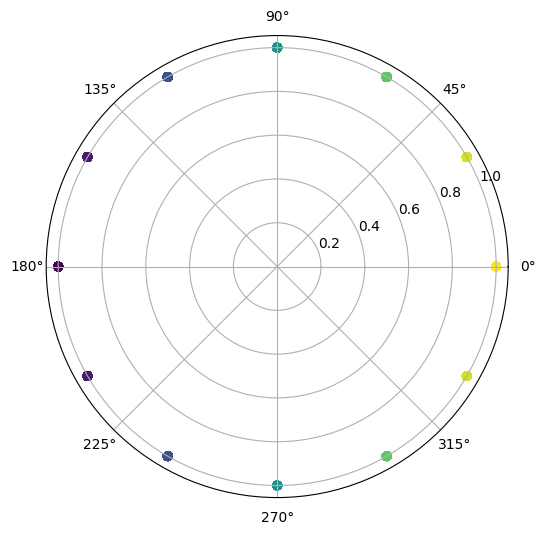

In [9]:
# Create a polar plot for visualizing the cyclic nature of the 'Month' feature
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))

# Convert the 'Month' values to radians and plot as a scatter, color-coded by the 'MonthCos' values
angles = np.radians(combined_df['month'] * 30)
ax.scatter(angles, np.ones(len(combined_df)), c=combined_df['MonthCos'], cmap='viridis')

# Display the plot
plt.show()


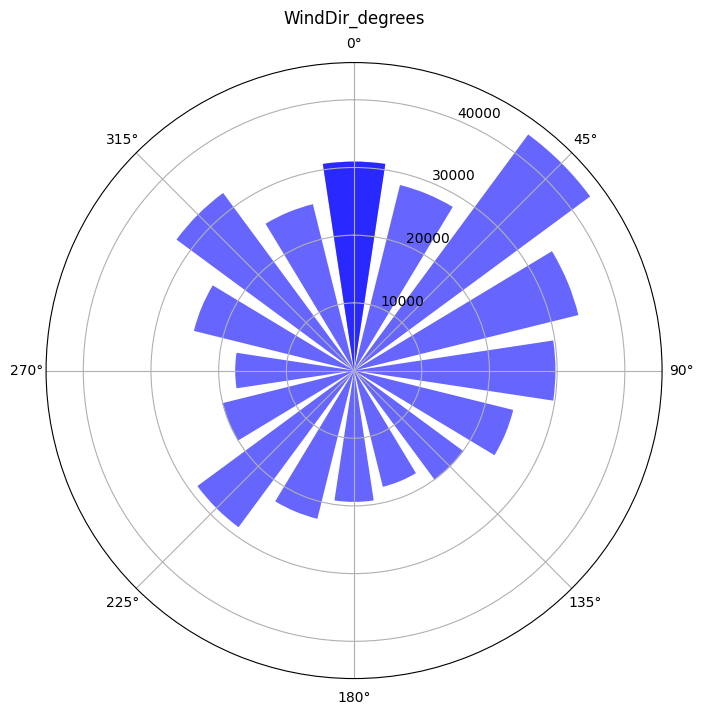

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Group data by wind direction and calculate frequency
direction_counts = combined_df.groupby('WindDir_degrees').size().reset_index(name='frequency')

# Convert wind direction to radians and prepare for plotting
angles = np.deg2rad(direction_counts['WindDir_degrees'])
frequency = direction_counts['frequency']

# Close the loop to make the plot circular
angles = np.concatenate((angles, [angles[0]]))
frequency = np.concatenate((frequency, [frequency[0]]))

# Create polar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.bar(angles, frequency, width=0.3, color='b', alpha=0.6)

# Customize plot: set angle to start at North and go clockwise
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

# Add title and display
ax.set_title('WindDir_degrees', va='bottom')
plt.show()

Adding Day fo Week, weekend and holidays

In [11]:
# Convert the index to a DatetimeIndex if it's not already
combined_df.index = pd.to_datetime(combined_df[['year', 'month', 'day', 'hour']])

# Extract the day of the week from the DatetimeIndex and assign it to a new column
combined_df['Day_of_Week'] = combined_df.index.weekday

# Create a 'Weekends' column indicating weekends (Saturday and Sunday) as 1, else 0
combined_df['Weekends'] = (combined_df['Day_of_Week'].isin([5, 6])).astype(int)

# Install the holidays library if you don't have it installed already
!pip install holidays

# Import the holidays library
import holidays

# Define the range of years for which holidays are to be retrieved
years = list(range(2013, 2018))

# Generate a collection of combined holidays for the specified years
combined_holidays = holidays.CountryHoliday('CN', years=years)

# Extract the holiday dates into a list
holiday_dates = list(combined_holidays.keys())

# Convert the holiday dates to pandas Timestamps for compatibility with the DataFrame index
formatted_holidays = [pd.Timestamp(date) for date in holiday_dates]

# Map each date in the DataFrame index to determine if it is a holiday (1 for holiday, 0 otherwise)
combined_df['Is_Holiday'] = combined_df.index.map(
    lambda date: 1 if date in formatted_holidays else 0
)

# Display the updated DataFrame
combined_df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,Hour_cos,MonthSin,MonthCos,DaySin,DayCos,Hour_12_06,Hour_03_09,Day_of_Week,Weekends,Is_Holiday
2013-03-01 00:00:00,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,...,1.000000,1.0,6.123234e-17,0.201299,0.97953,1.000000,0.000000,4,0,0
2013-03-01 01:00:00,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,...,0.965926,1.0,6.123234e-17,0.201299,0.97953,0.965926,0.258819,4,0,0
2013-03-01 02:00:00,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,...,0.866025,1.0,6.123234e-17,0.201299,0.97953,0.866025,0.500000,4,0,0
2013-03-01 03:00:00,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,...,0.707107,1.0,6.123234e-17,0.201299,0.97953,0.707107,0.707107,4,0,0
2013-03-01 04:00:00,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,...,0.500000,1.0,6.123234e-17,0.201299,0.97953,0.500000,0.866025,4,0,0


mapping months to seasons

In [12]:
# Define a function to map each month to its respective season
def map_to_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

# Create a 'Season' column by applying the mapping function to the month values
combined_df['Season'] = combined_df.index.month.map(map_to_season)

# Now, create separate columns for each season, where 1 indicates the season and 0 indicates it is not that season
combined_df['Spring'] = (combined_df['Season'] == 'Spring').astype(int)
combined_df['Summer'] = (combined_df['Season'] == 'Summer').astype(int)
combined_df['Fall'] = (combined_df['Season'] == 'Fall').astype(int)
combined_df['Winter'] = (combined_df['Season'] == 'Winter').astype(int)

# Display the updated DataFrame with one-hot encoded columns for each season
combined_df.head()


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,Hour_12_06,Hour_03_09,Day_of_Week,Weekends,Is_Holiday,Season,Spring,Summer,Fall,Winter
2013-03-01 00:00:00,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,...,1.000000,0.000000,4,0,0,Spring,1,0,0,0
2013-03-01 01:00:00,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,...,0.965926,0.258819,4,0,0,Spring,1,0,0,0
2013-03-01 02:00:00,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,...,0.866025,0.500000,4,0,0,Spring,1,0,0,0
2013-03-01 03:00:00,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,...,0.707107,0.707107,4,0,0,Spring,1,0,0,0
2013-03-01 04:00:00,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,...,0.500000,0.866025,4,0,0,Spring,1,0,0,0


**Adding AQI**

In [13]:
# Adjust these based on official standards for China/combined
pollutant_breakpoints = {
    'PM2.5': [
        (0, 12, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 350.4, 301, 400),
        (350.5, 500, 401, 500)
    ],
    'PM10': [
        (0, 54, 0, 50),
        (55, 154, 51, 100),
        (155, 254, 101, 150),
        (255, 354, 151, 200),
        (355, 424, 201, 300),
        (425, 504, 301, 400),
        (505, 604, 401, 500)
    ],
    'NO2': [
        (0, 40, 0, 50),
        (41, 80, 51, 100),
        (81, 180, 101, 150),
        (181, 280, 151, 200),
        (281, 400, 201, 300),
        (401, 500, 301, 400),
        (501, 600, 401, 500)
    ],
    'SO2': [
        (0, 50, 0, 50),
        (51, 150, 51, 100),
        (151, 250, 101, 150),
        (251, 350, 151, 200),
        (351, 500, 201, 300),
        (501, 600, 301, 400),
        (601, 800, 401, 500)
    ],
    'CO': [
        (0, 2, 0, 50),
        (2.1, 4, 51, 100),
        (4.1, 8, 101, 150),
        (8.1, 12, 151, 200),
        (12.1, 16, 201, 300),
        (16.1, 20, 301, 400),
        (20.1, 30, 401, 500)
    ],
    'O3': [
        (0, 50, 0, 50),
        (51, 100, 51, 100),
        (101, 168, 101, 150),
        (169, 240, 151, 200),
        (241, 320, 201, 300),
        (321, 400, 301, 400),
        (401, 500, 401, 500)
    ]
}

# Function to calculate AQI for any pollutant based on concentration and breakpoints
def calculate_aqi_for_pollutant(concentration, breakpoints):
    for bp in breakpoints:
        if bp[0] <= concentration <= bp[1]:
            return ((concentration - bp[0]) / (bp[1] - bp[0])) * (bp[3] - bp[2]) + bp[2]
    return None  # Return None if concentration is out of range

# Apply AQI calculation for multiple pollutants
for pollutant in pollutant_breakpoints.keys():
    combined_df[f'AQI_{pollutant}'] = combined_df[pollutant].apply(
        lambda x: calculate_aqi_for_pollutant(x, pollutant_breakpoints[pollutant])
    )

# Display the updated dataframe with AQI for each pollutant
print(combined_df[['AQI_PM2.5', 'AQI_PM10', 'AQI_NO2', 'AQI_SO2', 'AQI_CO', 'AQI_O3']])

combined_df.head()

                     AQI_PM2.5   AQI_PM10    AQI_NO2  AQI_SO2 AQI_CO  AQI_O3
2013-03-01 00:00:00  20.833333  12.962963  15.000000      4.0   None    85.0
2013-03-01 01:00:00  33.333333  11.111111  17.500000      6.0   None    84.0
2013-03-01 02:00:00  12.500000   5.555556  17.500000      5.0   None    83.0
2013-03-01 03:00:00  20.833333   4.629630  17.500000      5.0   None    84.0
2013-03-01 04:00:00  20.833333   4.629630  26.250000      6.0   None    77.0
...                        ...        ...        ...      ...    ...     ...
2017-02-28 19:00:00  52.892704  34.259259  45.000000      3.0   None    60.0
2017-02-28 20:00:00  67.613734  39.814815  59.794872      4.0   None    43.0
2017-02-28 21:00:00  59.201717  30.555556  48.750000      5.0   None    50.0
2017-02-28 22:00:00  45.833333  22.222222  58.538462      5.0   None    41.0
2017-02-28 23:00:00  57.098712  25.000000  66.076923      5.0   None    33.0

[420768 rows x 6 columns]


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,Spring,Summer,Fall,Winter,AQI_PM2.5,AQI_PM10,AQI_NO2,AQI_SO2,AQI_CO,AQI_O3
2013-03-01 00:00:00,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,...,1,0,0,0,20.833333,12.962963,15.00,4.0,None,85.0
2013-03-01 01:00:00,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,...,1,0,0,0,33.333333,11.111111,17.50,6.0,None,84.0
2013-03-01 02:00:00,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,...,1,0,0,0,12.500000,5.555556,17.50,5.0,None,83.0
2013-03-01 03:00:00,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,...,1,0,0,0,20.833333,4.629630,17.50,5.0,None,84.0
2013-03-01 04:00:00,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,...,1,0,0,0,20.833333,4.629630,26.25,6.0,None,77.0


combinig all AQIs

In [14]:
# Combine AQIs by selecting the maximum value for each row (worst pollutant)
combined_df['Combined_AQI'] = combined_df[['AQI_PM2.5', 'AQI_PM10', 'AQI_NO2', 'AQI_SO2', 'AQI_CO', 'AQI_O3']].max(axis=1)

# Display the updated dataframe with Combined AQI
print(combined_df[['AQI_PM2.5', 'AQI_PM10', 'AQI_NO2', 'AQI_SO2', 'AQI_CO', 'AQI_O3', 'Combined_AQI']].head())

combined_df.head()

                     AQI_PM2.5   AQI_PM10  AQI_NO2  AQI_SO2 AQI_CO  AQI_O3  \
2013-03-01 00:00:00  20.833333  12.962963    15.00      4.0   None    85.0   
2013-03-01 01:00:00  33.333333  11.111111    17.50      6.0   None    84.0   
2013-03-01 02:00:00  12.500000   5.555556    17.50      5.0   None    83.0   
2013-03-01 03:00:00  20.833333   4.629630    17.50      5.0   None    84.0   
2013-03-01 04:00:00  20.833333   4.629630    26.25      6.0   None    77.0   

                    Combined_AQI  
2013-03-01 00:00:00         85.0  
2013-03-01 01:00:00         84.0  
2013-03-01 02:00:00         83.0  
2013-03-01 03:00:00         84.0  
2013-03-01 04:00:00         77.0  


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,Summer,Fall,Winter,AQI_PM2.5,AQI_PM10,AQI_NO2,AQI_SO2,AQI_CO,AQI_O3,Combined_AQI
2013-03-01 00:00:00,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,...,0,0,0,20.833333,12.962963,15.00,4.0,None,85.0,85.0
2013-03-01 01:00:00,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,...,0,0,0,33.333333,11.111111,17.50,6.0,None,84.0,84.0
2013-03-01 02:00:00,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,...,0,0,0,12.500000,5.555556,17.50,5.0,None,83.0,83.0
2013-03-01 03:00:00,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,...,0,0,0,20.833333,4.629630,17.50,5.0,None,84.0,84.0
2013-03-01 04:00:00,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,...,0,0,0,20.833333,4.629630,26.25,6.0,None,77.0,77.0


**Calculate Air Quality Health Index (AQHI)**
The AQHI formula used in this code is based on the methodology provided by Health Canada for calculating the Air Quality Health Index (AQHI).This formula can be found in Health Canada's AQHI technical document or their official website.

 https://en.wikipedia.org/wiki/Air_Quality_Health_Index_%28Canada%29#:~:text=The%20national%20AQHI%20is%20based%20on%20three%2Dhour%20average%20concentrations,billion%20%28ppb%29%20while%20PM2"

In [15]:
from math import exp

# Function to calculate AQHI
def calculate_aqhi(row):
    if any(pd.isna(row[feature]) for feature in ['O3', 'NO2', 'PM2.5']):
        return float('nan')
    # Calculate the sum of the exponential terms using a list
    terms = [
        exp(0.000871 * row['NO2']) - 1,
        exp(0.000537 * row['O3']) - 1,
        exp(0.000487 * row['PM2.5']) - 1
    ]
    return (10 / 18) * 100 * sum(terms)

# Apply AQHI calculation
combined_df['AQHI'] = combined_df.apply(calculate_aqhi, axis=1)

# Display the AQHI column along with relevant features
print(combined_df[['O3', 'NO2', 'PM2.5', 'AQHI']].head())

combined_df.head()

                       O3   NO2  PM2.5      AQHI
2013-03-01 00:00:00  85.0  12.0    5.0  3.313753
2013-03-01 01:00:00  84.0  14.0    8.0  3.461838
2013-03-01 02:00:00  83.0  14.0    3.0  3.294996
2013-03-01 03:00:00  84.0  14.0    5.0  3.380414
2013-03-01 04:00:00  77.0  21.0    5.0  3.506280


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,Fall,Winter,AQI_PM2.5,AQI_PM10,AQI_NO2,AQI_SO2,AQI_CO,AQI_O3,Combined_AQI,AQHI
2013-03-01 00:00:00,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,...,0,0,20.833333,12.962963,15.00,4.0,None,85.0,85.0,3.313753
2013-03-01 01:00:00,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,...,0,0,33.333333,11.111111,17.50,6.0,None,84.0,84.0,3.461838
2013-03-01 02:00:00,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,...,0,0,12.500000,5.555556,17.50,5.0,None,83.0,83.0,3.294996
2013-03-01 03:00:00,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,...,0,0,20.833333,4.629630,17.50,5.0,None,84.0,84.0,3.380414
2013-03-01 04:00:00,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,...,0,0,20.833333,4.629630,26.25,6.0,None,77.0,77.0,3.506280


Comparative Statistical Results of AQI vs AQHI

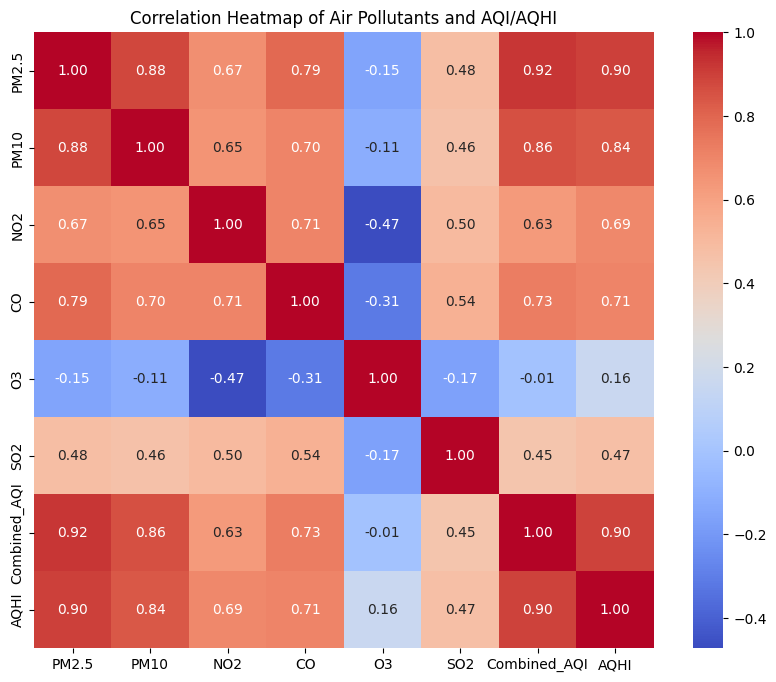

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only air pollutant columns and Combined AQI/AQHI for the heatmap
pollutant_columns = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2', 'Combined_AQI', 'AQHI']
heatmap_data = combined_df[pollutant_columns]

# Compute the correlation matrix
corrmat = heatmap_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corrmat, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Air Pollutants and AQI/AQHI')
plt.show()

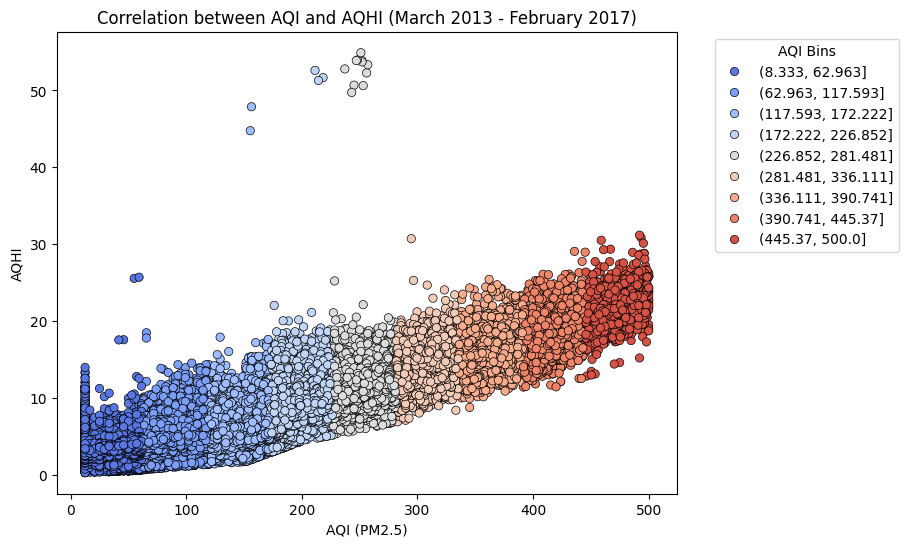

Correlation coefficient between AQI and AQHI: 0.8859029016840567


In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Remove duplicate rows and reset the index
combined_df = combined_df.drop_duplicates().reset_index(drop=True)

# Bin the AQI_PM2.5 values for better visualization in the scatterplot
combined_df['AQI_PM2.5_bins'] = pd.cut(
    combined_df['AQI_PM2.5'],
    bins=np.linspace(combined_df['AQI_PM2.5'].min(), combined_df['AQI_PM2.5'].max(), 10)
)

# Plot the correlation between AQI and AQHI
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=combined_df['AQI_PM2.5'],
    y=combined_df['AQHI'],
    hue=combined_df['AQI_PM2.5_bins'],
    palette='coolwarm',
    edgecolor='black'
)
plt.title('Correlation between AQI and AQHI (March 2013 - February 2017)')
plt.xlabel('AQI (PM2.5)')
plt.ylabel('AQHI')
plt.legend(title='AQI Bins', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.show()

# Calculate and display the correlation coefficient
correlation = combined_df[['AQI_PM2.5', 'AQHI']].corr().iloc[0, 1]
print(f"Correlation coefficient between AQI and AQHI: {correlation}")


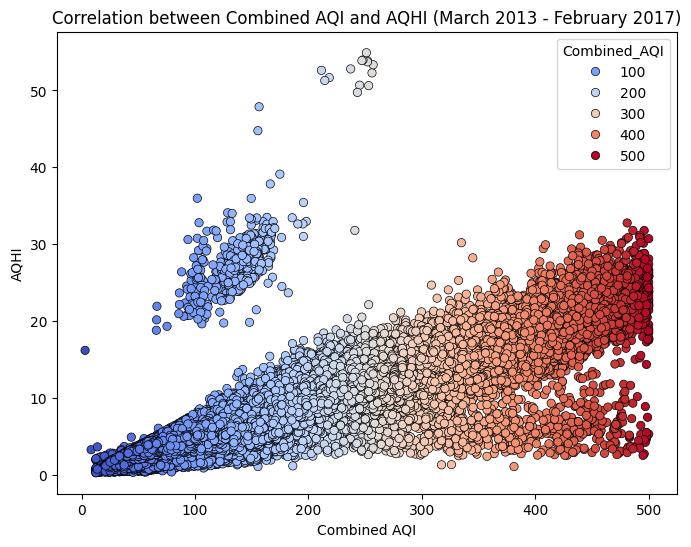

Correlation coefficient between Combined AQI and AQHI: 0.8960495659039611


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine AQIs by selecting the maximum value for each row (worst pollutant)
combined_df['Combined_AQI'] = combined_df[['AQI_PM2.5', 'AQI_PM10', 'AQI_NO2', 'AQI_SO2', 'AQI_CO', 'AQI_O3']].max(axis=1)

# Plot the correlation between Combined AQI and AQHI with different colors for each point
plt.figure(figsize=(8, 6))
sns.scatterplot(x=combined_df['Combined_AQI'], y=combined_df['AQHI'], hue=combined_df['Combined_AQI'], palette='coolwarm', edgecolor='black')
plt.title('Correlation between Combined AQI and AQHI (March 2013 - February 2017)')
plt.xlabel('Combined AQI')
plt.ylabel('AQHI')

# Show the plot
plt.show()

# Calculate the correlation coefficient between Combined AQI and AQHI
correlation = combined_df[['Combined_AQI', 'AQHI']].corr().iloc[0, 1]
print(f"Correlation coefficient between Combined AQI and AQHI: {correlation}")


Combined_AQI     4971
AQHI            22479
dtype: int64


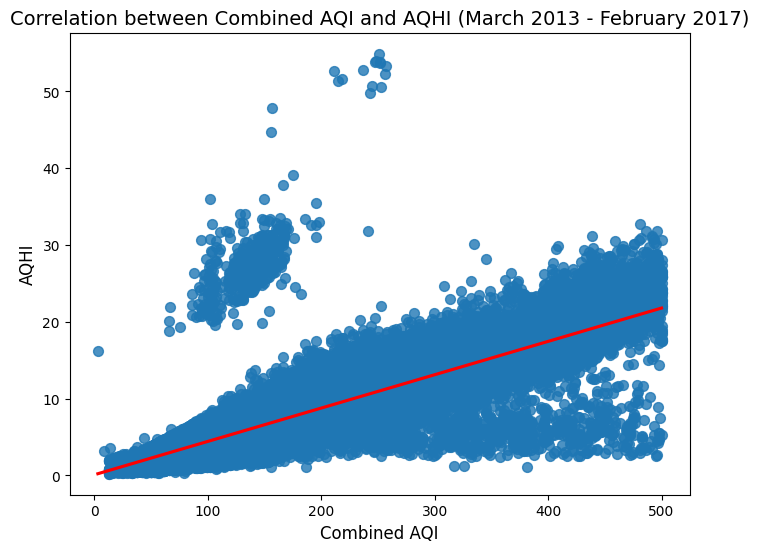

Correlation coefficient between Combined AQI and AQHI: 0.8960495659039611


In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'combined_df' is already your combined DataFrame

# 1. Convert 'Combined_AQI' and 'AQHI' to numeric, forcing invalid values to NaN
combined_df['Combined_AQI'] = pd.to_numeric(combined_df['Combined_AQI'], errors='coerce')
combined_df['AQHI'] = pd.to_numeric(combined_df['AQHI'], errors='coerce')

# 2. Check for NaN values in 'Combined_AQI' and 'AQHI' after conversion
print(combined_df[['Combined_AQI', 'AQHI']].isna().sum())

# 3. Drop rows with NaN values in 'Combined_AQI' or 'AQHI'
combined_df = combined_df.dropna(subset=['Combined_AQI', 'AQHI'])

# 4. Plot the correlation between Combined AQI and AQHI with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x=combined_df['Combined_AQI'], y=combined_df['AQHI'], scatter_kws={'s': 50}, line_kws={'color': 'red'}, ci=None)
plt.title('Correlation between Combined AQI and AQHI (March 2013 - February 2017)', fontsize=14)
plt.xlabel('Combined AQI', fontsize=12)
plt.ylabel('AQHI', fontsize=12)

# Show the plot
plt.show()

# 5. Calculate the correlation coefficient between Combined AQI and AQHI
correlation = combined_df[['Combined_AQI', 'AQHI']].corr().iloc[0, 1]
print(f"Correlation coefficient between Combined AQI and AQHI: {correlation}")


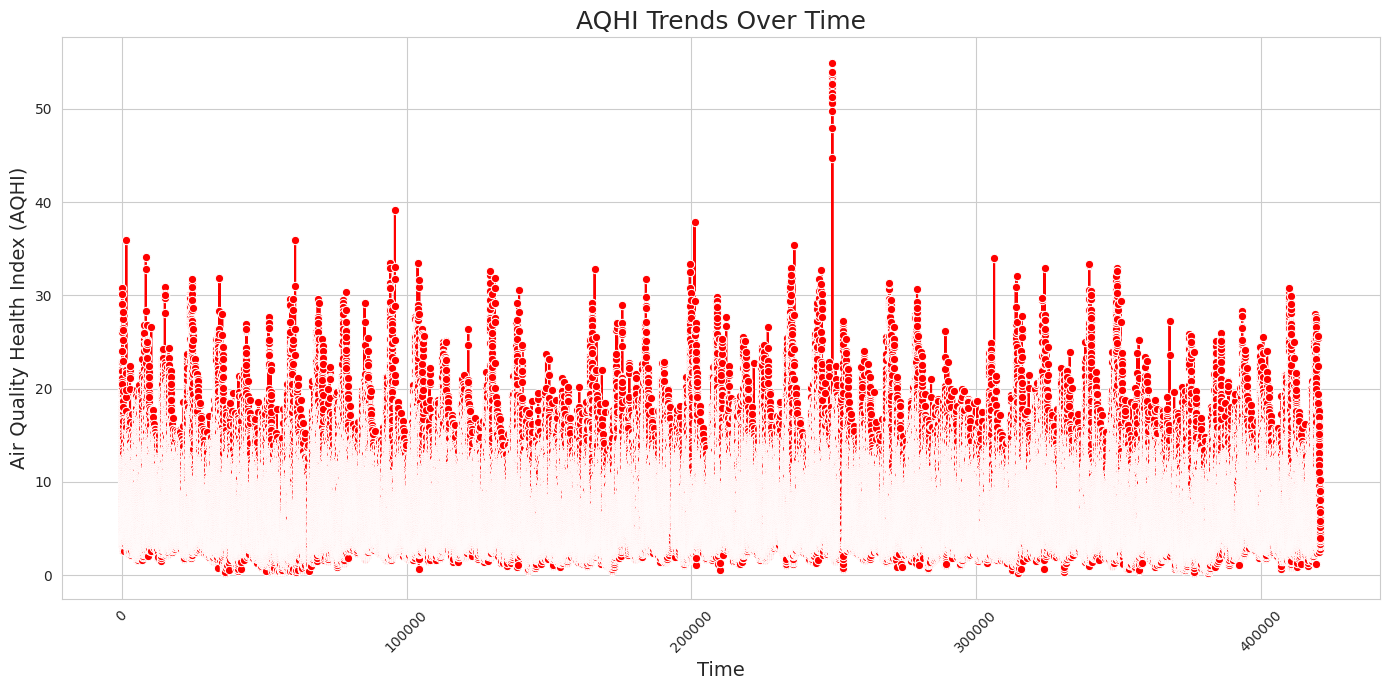

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the seaborn style for the plot
sns.set_style("whitegrid")

# Create the figure with a specified size
plt.figure(figsize=(14, 7))

# Line plot with markers for AQHI over time
sns.lineplot(data=combined_df, x=combined_df.index, y='AQHI', marker="o", color="r")

# Set the plot's title and axis labels
plt.title('AQHI Trends Over Time', fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Air Quality Health Index (AQHI)', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Ensure tight layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

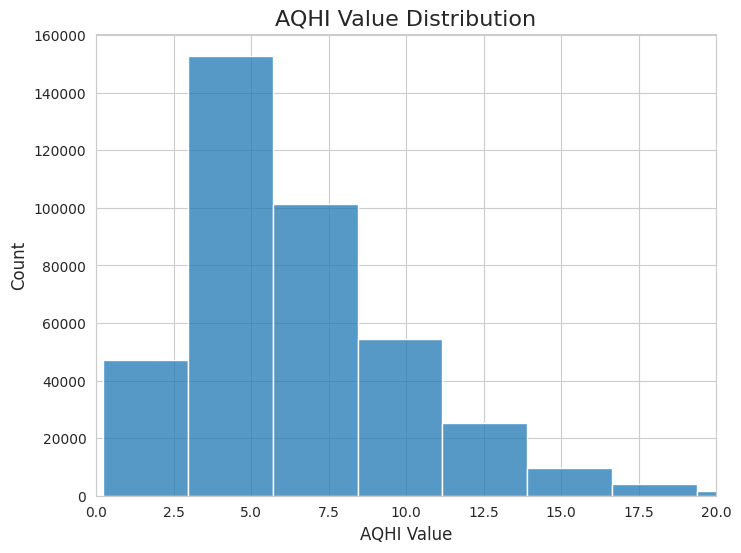

In [21]:
# Set the style to "whitegrid"
sns.set_style("whitegrid")

# Plot the AQHI distribution
plt.figure(figsize=(8, 6))
sns.histplot(combined_df, x='AQHI', bins=20, kde=False)

# Customize plot title and labels
plt.title('AQHI Value Distribution', fontsize=16)
plt.xlabel('AQHI Value', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Limit the x-axis range to 0-20
plt.xlim(0, 20)

# Display the plot
plt.show()


Skewness of AQHI: 1.5688


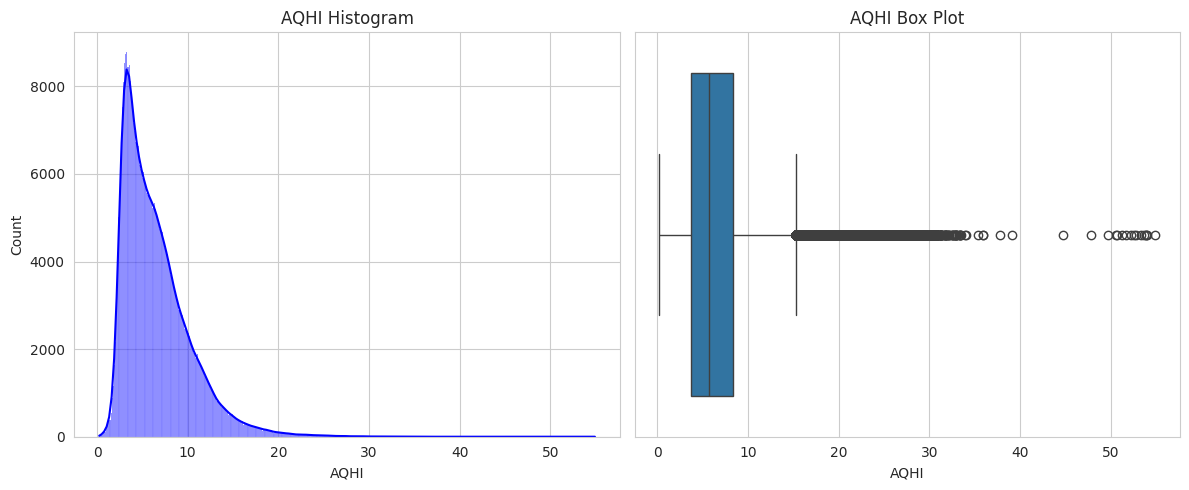

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature to examine
feature = ['AQHI']

# Set up the figure for subplots
# Check if there's more than one pollutant for subplot dimensions
if len(feature) > 1:
    fig, axes = plt.subplots(nrows=len(feature), ncols=2, figsize=(12, 5 * len(feature)))
else:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    axes = axes.reshape(1, -1)  # Reshape to 2D for consistency

# Loop to generate histograms and boxplots for AQHI
for i, pollutant in enumerate(feature):
    # Print skewness of the AQHI
    # The change is on this line: Use pollutant instead of feature,
    # and access the element of the list feature using feature[i]
    print(f"Skewness of {pollutant}: {combined_df[pollutant].skew():.4f}")

    # Plot histogram with KDE
    sns.histplot(combined_df[pollutant], ax=axes[i, 0], color='b', kde=True)
    axes[i, 0].set_title(f'{pollutant} Histogram')

    # Plot boxplot
    sns.boxplot(x=combined_df[pollutant], ax=axes[i, 1])
    # The change is on this line: Use pollutant instead of features
    axes[i, 1].set_title(f'{pollutant} Box Plot')

# Adjust layout and show
plt.tight_layout()
plt.show()

**Lag Featuresand Rolling Features**

In [23]:
# Function to create lag features
def create_lag_features(df, features, lag_hours=24):
    for feature in features:
        for i in range(1, lag_hours + 1):
            df[f'{feature}_Lag_{i}'] = df[feature].shift(i)
    return df


# Function to create past features (day-based lags)
def create_past_features(df, features, days=[1, 2, 3, 7]):
    for feature in features:
        for day in days:
            df[f'{feature}_{day}day_ago'] = df[feature].shift(24 * day)
    return df


# Function to define target variables for forecasting
def target_definition(df, features, forecast_hours=[1, 2, 3]):
    for feature in features:
        for fh in forecast_hours:
            df[f'Target_{feature}_{fh}h'] = df[feature].shift(-fh)
    return df


# Function to create rolling features for selected features
def create_rolling_features(df, features, window_sizes=[6, 12, 24]):
    for feature in features:
        for window_size in window_sizes:
            df[f'{feature}_Mean_{window_size}h'] = df[feature].rolling(window=window_size).mean()
            df[f'{feature}_Std_{window_size}h'] = df[feature].rolling(window=window_size).std()
    return df


# Copy the original DataFrame for time series feature engineering
combined_df = combined_df.copy()

# Features for lag and rolling feature creation
relevant_features = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'AQHI']

# Create lag features
combined_df = create_lag_features(combined_df, relevant_features)

# Create rolling features
combined_df = create_rolling_features(combined_df, relevant_features)

combined_df.head()


<ipython-input-23-a7484ed7ceda>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_Lag_{i}'] = df[feature].shift(i)
<ipython-input-23-a7484ed7ceda>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_Lag_{i}'] = df[feature].shift(i)
<ipython-input-23-a7484ed7ceda>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,RAIN_Mean_12h,RAIN_Std_12h,RAIN_Mean_24h,RAIN_Std_24h,AQHI_Mean_6h,AQHI_Std_6h,AQHI_Mean_12h,AQHI_Std_12h,AQHI_Mean_24h,AQHI_Std_24h
0,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**EDA after Feature Engineering**

Handling Missing Values

In [24]:
# Check for missing values in numerical features
numerical_features = combined_df.select_dtypes(include=np.number).columns
missing_numerical = combined_df[numerical_features].isnull().sum()
print("Missing values in numerical features:\n", missing_numerical)

# Check for missing values in categorical features
categorical_features = combined_df.select_dtypes(exclude=np.number).columns
missing_categorical = combined_df[categorical_features].isnull().sum()
print("\nMissing values in categorical features:\n", missing_categorical)

Missing values in numerical features:
 No                0
year              0
month             0
day               0
hour              0
                 ..
AQHI_Std_6h       5
AQHI_Mean_12h    11
AQHI_Std_12h     11
AQHI_Mean_24h    23
AQHI_Std_24h     23
Length: 371, dtype: int64

Missing values in categorical features:
 wd                  1748
station                0
Stations               0
Timestamp              0
Season                 0
AQI_CO            398289
AQI_PM2.5_bins       910
dtype: int64


In [25]:
# Apply linear interpolation to all numerical features
for col in combined_df.select_dtypes(include=np.number).columns:
    combined_df[col] = combined_df[col].interpolate(method='linear')

combined_df.isnull().sum()


,0
No,0
year,0
month,0
day,0
hour,0
...,...
AQHI_Std_6h,5
AQHI_Mean_12h,11
AQHI_Std_12h,11
AQHI_Mean_24h,23


In [26]:

# Apply linear interpolation to numerical features
for col in combined_df.select_dtypes(include=np.number).columns:
    combined_df[col] = combined_df[col].interpolate(method='linear')

# Fill missing values in categorical features with the most frequent value
for col in combined_df.select_dtypes(exclude=np.number).columns:
    mode_value = combined_df[col].mode()
    if not mode_value.empty:
        combined_df[col] = combined_df[col].fillna(mode_value[0])
    else:
        combined_df[col] = combined_df[col].fillna('Unknown')  # Or another suitable value

combined_df.isnull().sum()

,0
No,0
year,0
month,0
day,0
hour,0
...,...
AQHI_Std_6h,5
AQHI_Mean_12h,11
AQHI_Std_12h,11
AQHI_Mean_24h,23


Detected Outliers

Outliers in AQHI:
            No  year  month  day  hour  PM2.5   PM10   SO2    NO2      CO  ...  \
111       112  2013      3    5    15  163.0  192.0  85.0  211.0  3000.0  ...   
112       113  2013      3    5    16  192.0  206.0  95.0  195.0  2700.0  ...   
113       114  2013      3    5    17  203.0  230.0  93.0  163.0  2100.0  ...   
114       115  2013      3    5    18  195.0  216.0  92.0  156.0  2000.0  ...   
115       116  2013      3    5    19  185.0  204.0  97.0  175.0  2200.0  ...   
...       ...   ...    ...  ...   ...    ...    ...   ...    ...     ...  ...   
420456  34753  2017      2   16     0  267.0  267.0  60.0  155.0  2800.0  ...   
420457  34754  2017      2   16     1  262.0  262.0  52.0  147.0  2500.0  ...   
420458  34755  2017      2   16     2  262.0  262.0  38.0  133.0  2000.0  ...   
420459  34756  2017      2   16     3  259.0  259.0  40.0  133.0  3000.0  ...   
420460  34757  2017      2   16     4  260.0  260.0  38.0  129.0  2700.0  ...   

        

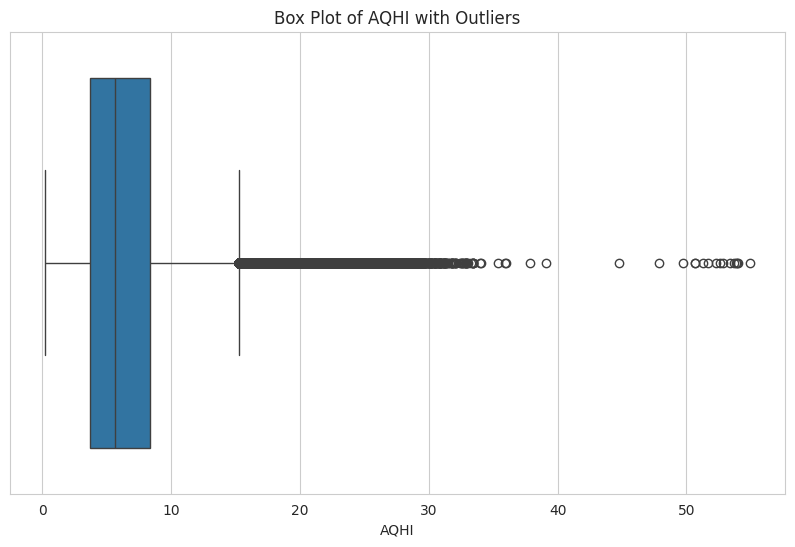

Outliers in AQHI (Z-score method):
            No  year  month  day  hour  PM2.5   PM10    SO2    NO2      CO  \
111       112  2013      3    5    15  163.0  192.0   85.0  211.0  3000.0   
112       113  2013      3    5    16  192.0  206.0   95.0  195.0  2700.0   
118       119  2013      3    5    22  235.0  238.0  123.0  185.0  3299.0   
119       120  2013      3    5    23  242.0  243.0  122.0  181.0  3299.0   
150       151  2013      3    7     6  314.0  337.0   88.0  165.0  6500.0   
...       ...   ...    ...  ...   ...    ...    ...    ...    ...     ...   
420184  34481  2017      2    4    16  341.0  380.0   65.0  145.0  3500.0   
420185  34482  2017      2    4    17  346.0  362.0   70.0  135.0  3200.0   
420186  34483  2017      2    4    18  365.0  391.0   71.0  144.0  3300.0   
420187  34484  2017      2    4    19  341.0  341.0   57.0  161.0  3300.0   
420456  34753  2017      2   16     0  267.0  267.0   60.0  155.0  2800.0   

        ...  RAIN_Mean_12h  RAIN_Std_12

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'combined_df' is your DataFrame and 'AQHI' is the column you want to analyze

def detect_outliers_iqr(data, column_name, threshold=1.5):
    """
    Detects outliers in a given column using the Interquartile Range (IQR) method.

    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to analyze.
        threshold (float, optional): The IQR threshold. Defaults to 1.5.

    Returns:
        pd.DataFrame: A DataFrame containing the outliers.
    """
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]
    return outliers

# Example usage
outliers_aqhi = detect_outliers_iqr(combined_df, 'AQHI')

# Print the outliers
print("Outliers in AQHI:\n", outliers_aqhi)

# Visualize outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=combined_df['AQHI'])
plt.title('Box Plot of AQHI with Outliers')
plt.show()


def detect_outliers_zscore(data, column_name, threshold=3):
    """
    Detects outliers in a given column using the Z-score method.

    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to analyze.
        threshold (float, optional): The Z-score threshold. Defaults to 3.

    Returns:
        pd.DataFrame: A DataFrame containing the outliers.
    """
    z_scores = np.abs((data[column_name] - data[column_name].mean()) / data[column_name].std())
    outliers = data[z_scores > threshold]
    return outliers

# Example usage
outliers_aqhi_zscore = detect_outliers_zscore(combined_df, 'AQHI')

# Print the outliers
print("Outliers in AQHI (Z-score method):\n", outliers_aqhi_zscore)


In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Display initial shape
print(f'Before: Outliers Treatment with IQR {combined_df.shape}')
# Creating a copy of the DataFrame to work with
combined_df_IQR = combined_df.copy()

# Selecting only numeric data types for outlier detection
numeric_columns = combined_df_IQR.select_dtypes(include=['float64', 'int64']).columns

# Replace outliers in each column
for col in numeric_columns:
    if col != 'RAIN':  # Skip 'RAIN' column for outlier replacement
        # Calculate Q1, Q3 and IQR
        Q1 = combined_df_IQR[col].quantile(0.25)
        Q3 = combined_df_IQR[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Define a mask for outliers
        outlier_mask = (combined_df_IQR[col] < lower_bound) | (combined_df_IQR[col] > upper_bound)

        # Replace outliers with NaN to ease the calculation of neighbors' mean
        combined_df_IQR.loc[outlier_mask, col] = np.nan

        # Interpolate missing values using mean of neighboring values
        combined_df_IQR[col] = combined_df_IQR[col].interpolate(method='linear', limit_direction='both')

# Display shape after outlier treatment
print(f'After: Outliers Replaced with Neighbors Mean {combined_df_IQR.shape}')

Before: Outliers Treatment with IQR (398289, 378)
After: Outliers Replaced with Neighbors Mean (398289, 378)


Dropping less relevent features

In [30]:
# prompt: write a code to drop so irrelevent columns

# Assuming 'combined_df' is your DataFrame and the code you provided has already run.

# List of columns to drop.  Customize this based on your analysis.
columns_to_drop = ['No','hour',	'wd',	'WSPM','hour','month','day','Hour_12_06',	'Hour_03_09', 'station',	'Stations','season','AQI_PM2.5',
                   'AQI_PM10', 'AQI_NO2', 'AQI_SO2', 'AQI_CO', 'AQI_O3', 'Combined_AQI', ]

# Drop the columns.
combined_df = combined_df.drop(columns=columns_to_drop, errors='ignore')

# Display the remaining columns.
combined_df.columns

combined_df

,year,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,...,RAIN_Mean_12h,RAIN_Std_12h,RAIN_Mean_24h,RAIN_Std_24h,AQHI_Mean_6h,AQHI_Std_6h,AQHI_Mean_12h,AQHI_Std_12h,AQHI_Mean_24h,AQHI_Std_24h
0,2013,5.0,14.0,4.0,12.0,200.0,85.0,-0.5,1024.5,-21.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013,8.0,12.0,6.0,14.0,200.0,84.0,-0.7,1025.1,-22.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013,3.0,6.0,5.0,14.0,200.0,83.0,-1.2,1025.3,-24.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013,5.0,5.0,5.0,14.0,200.0,84.0,-1.4,1026.2,-25.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013,5.0,5.0,6.0,21.0,200.0,77.0,-1.9,1027.1,-24.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,2017,13.0,37.0,3.0,36.0,400.0,60.0,12.5,1013.5,-16.2,...,0.0,0.0,0.0,0.0,3.697403,0.183237,3.536698,0.248666,5.380975,2.160863
420764,2017,20.0,43.0,4.0,48.0,500.0,43.0,11.6,1013.6,-15.1,...,0.0,0.0,0.0,0.0,3.837105,0.206512,3.591318,0.316498,5.262393,2.142766
420765,2017,16.0,33.0,5.0,39.0,500.0,50.0,10.8,1014.2,-13.3,...,0.0,0.0,0.0,0.0,3.864331,0.195732,3.609860,0.326204,5.145900,2.139370
420766,2017,11.0,24.0,5.0,47.0,500.0,41.0,10.5,1014.4,-12.9,...,0.0,0.0,0.0,0.0,3.892956,0.175778,3.656786,0.316928,5.050944,2.144105
